In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import copy
import matplotlib as mpl
from matplotlib.colors import ListedColormap ,LinearSegmentedColormap, to_rgba
import matplotlib.patches as patches
import os
import scipy.linalg as sclinalg
from matplotlib.collections import PolyCollection
from scipy.spatial import KDTree
%xmode Plain

Exception reporting mode: Plain


In [2]:
def sph_to_cart(phi,theta): #for r = 1
    return np.array([np.cos(phi)*np.sin(theta),np.sin(phi)*np.sin(theta),np.cos(theta)])

def cart_to_sph(x,y,z):
    return np.array([np.arctan2(y,x),np.arctan2(np.sqrt(x**2+y**2),z)])
def fresnel_s(theta_i): #van space naar water
    return abs((np.cos(theta_i)-1.33*np.sqrt(1-(1/1.33*np.sin(theta_i))**2))/(np.cos(theta_i)+(1.33*np.sqrt(1-(1/1.33*np.sin(theta_i))**2))))**2



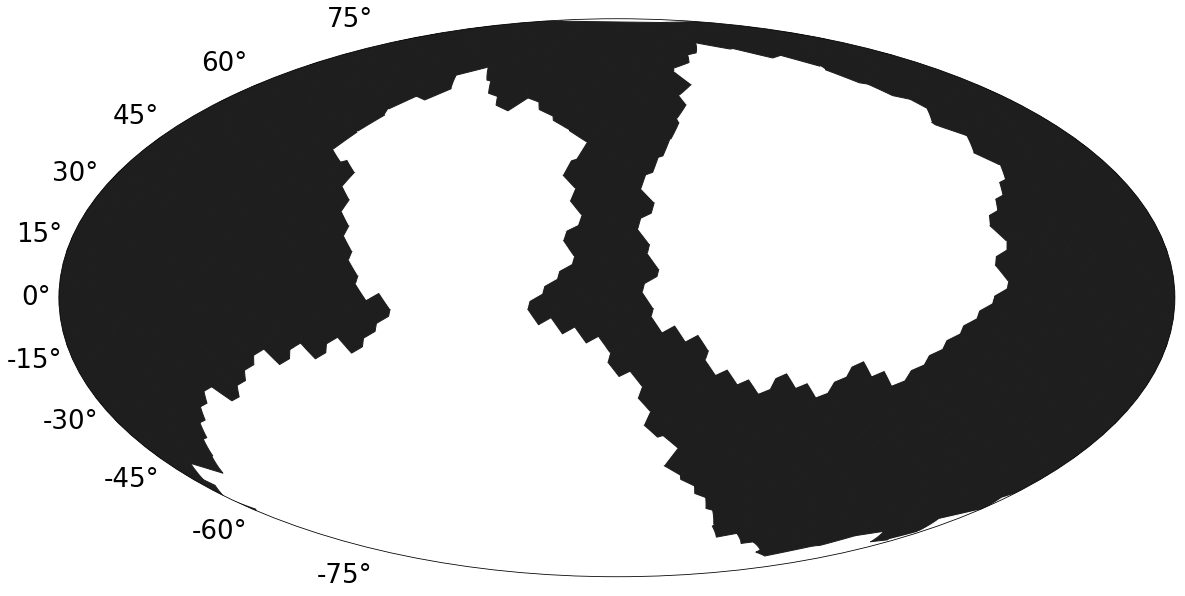

In [3]:
numpoints = 1001
seed_no = 0
models = ('lambert','LomSee','water')
model = models[2]
albedo_map = np.loadtxt('albedos/albedo_map'+str(seed_no)+'_n'+str(numpoints)+'.txt',delimiter=',')
alts = np.loadtxt('alts/alts_'+str(seed_no)+'n'+str(numpoints)+'.txt',delimiter=',')

voronoi_grid = np.loadtxt('voronoi_grid_n'+str(numpoints),delimiter=',')
plot_facets_vor = np.load('plot_facets_n'+str(numpoints)+'.npy',allow_pickle=',')
phi_grid,theta_grid,area_grid = voronoi_grid.transpose()

mpl.rcParams.update({'font.size': 26})
if model == models[2]:
    albedo_map[np.where(albedo_map<0.1)] = 0.1
    albedo_map[np.where(albedo_map>0.11)] = 0
    albedo_map[np.where(albedo_map==0.1)] = 1
    
    blues = mpl.cm.get_cmap('Blues',4000) #colors
    greys = mpl.cm.get_cmap('Greys',4000)
    
    N = 256
    y2 = greys(np.linspace(0.2,0,int(N/2))) #ocean colors, for half the heights
    y1 = greys(np.linspace(0.9,1,int(N/2)))    #forest colors
    y = np.vstack((y1,y2))

    cmap_albedo = LinearSegmentedColormap.from_list('custom earth', y, N=256)

    fig = plt.figure(figsize = [20,20])
    ax = fig.add_subplot(111,projection='mollweide')
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = cmap_albedo)
    cmapplot.set_array([])
#     cb = fig.colorbar(cmapplot, ax=ax, orientation='horizontal', label='Albedo',shrink=1/1.5, aspect=40,pad=-0.6)

    # plot the facets
    ax.add_collection(PolyCollection(plot_facets_vor,array=albedo_map,cmap=cmap_albedo,edgecolor='face',norm=norm)) #plot majority of facets
    i=0
    for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
        c = cmap_albedo(albedo_map[i])
        if np.any(facet_sph[:,0]>np.pi):
            ax.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
        elif np.any(facet_sph[:,0]<-np.pi):
            ax.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
        i+=1

    ax.set_xticklabels([])
#     ax.set_yticklabels([])
    plt.savefig('albedo_map0_water_n1001.png',dpi=100,bbox_inches='tight')
    plt.show()
else:   
    alts = alts-np.mean(alts)
    max_alt = max(alts)
    min_alt = min(alts)
    # norm_alts = (alts-min_alt)/(max_alt-min_alt)
    snowheight = 0.8
    soilheight = 0.4
    waterheight = 0

    albedo_map = np.zeros(numpoints) #ocean

    for i in range(numpoints):
        if alts[i] >= snowheight*max_alt:#snow
            albedo_map[i] = 0.6+(alts[i]-snowheight*max_alt)/(max_alt-snowheight*max_alt)*0.3
        elif alts[i] < 0.0: #water
            albedo_map[i] = 0.06
        elif (alts[i] >= soilheight*max_alt and alts[i]<snowheight*max_alt): #soil
            albedo_map[i] = 0.3+(alts[i]-soilheight*max_alt)/(snowheight*max_alt-soilheight*max_alt)*0.2
        elif (alts[i] >= waterheight*max_alt and alts[i]<soilheight*max_alt): #forest
            albedo_map[i] = 0.1+(alts[i]-waterheight*max_alt)/(soilheight*max_alt-waterheight*max_alt)*0.2 
    albedos = np.array([0.06,0.15,0.4,0.8])
    snowheight = 0.8
    soilheight = 0.4
    gist_earth = mpl.cm.get_cmap('gist_earth',4000) #colors
    N = 256
    y1 = gist_earth(np.linspace(0.02,0.15,int(N*0.1))) #ocean colors
    y2 = gist_earth(np.linspace(0.3,0.5,int(N*0.2))) #forest colors
    y3 = gist_earth(np.linspace(0.7,0.85,int(N*0.2))) #soil colors
    y4 = gist_earth(np.linspace(0.93,1,int(N*.3))) #snow colors
    y = np.vstack((y1,y2,y3,y4))

    cmap_albedo = LinearSegmentedColormap.from_list('custom earth', y, N=256)

    fig = plt.figure(figsize = [20,20])
    ax = fig.add_subplot(111,projection='mollweide')
    norm = mpl.colors.Normalize(vmin=0, vmax=0.8)
    cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = cmap_albedo)
    cmapplot.set_array([])
    cb = fig.colorbar(cmapplot, ax=ax, orientation='horizontal', label='Albedo',shrink=1/1.5, aspect=40,pad=-0.6)

    # plot the facets
    ax.add_collection(PolyCollection(plot_facets_vor,array=albedo_map,cmap=cmap_albedo,edgecolor='face',norm=norm)) #plot majority of facets
    i=0
    for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
        c = cmap_albedo(albedo_map[i]/0.8)
        if np.any(facet_sph[:,0]>np.pi):
            ax.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
        elif np.any(facet_sph[:,0]<-np.pi):
            ax.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
        i+=1

    ax.set_xticklabels([])
#     ax.set_yticklabels([])
    plt.show()

In [4]:
%%time
'''
Parameters
'''
res = len(phi_grid)
rho = 6.371e6
R = 1.496e11
alpha = 90/180*np.pi
beta = 30/180*np.pi

day = 24
year = 365*day
omega_day = 2*np.pi/day
omega_year = 2*np.pi/year


delta_t = 1
hours = np.arange(0,24)
time_array = np.array([])

N_ave = 187

burst=False
time_array = np.linspace(0,year,1500) #a number of time measurements spread evenly throughout a year
# filename = 'f_curves/edge_t'+str(len(time_array))+'.npy'

# for i in range(200): #every hour for a whole year of 365 days
#     time_array = np.append(time_array,hours+i*year/200)

# burst=False
# for i in range(8): #8 days spread out throughout the year 128 images taken over a couple of hours
#     time_array = np.append(time_array,np.linspace(0,2,2**7) + i*year/8)
# filename = 'f_curves/edge_tburst2h_'+str(len(time_array))+'.txt' #burst measurements, 2hours

time_res = len(time_array)
# '''
# Albedo-map
# '''
# A = np.ones(res)
# time = np.linspace(0,1,round(year/delta_t))*365


'''
Euler rotation matrices
'''
def positive(arg):
    return(arg+abs(arg))/2

def y_rotation(angle):
    Y = np.array([[np.cos(angle),0,np.sin(angle)],[0,1,0],
                  [-np.sin(angle),0,np.cos(angle)]])
    return Y

def z_rotation(angle):
    Z = np.array([[np.cos(angle),-np.sin(angle),0],
                  [np.sin(angle),np.cos(angle),0],[0,0,1]])
    return Z



R_equinox = z_rotation(alpha)
R_tilt = y_rotation(beta)
R_axial = np.matmul(R_equinox,R_tilt)


'''
Initialize transfromation matrices (edge-on, face-on)
'''
T = np.zeros((time_res,res))

# T1 = T.copy()

'''
Observer
'''
o_vec = np.array([1,0,0]) #gamma = pi/2; edge-on
# o_vec_1 = np.array([0,0,1]) #gamma = 0; face-on


'''
Compute matrix elements
'''
if model == models[0]: #lambertian
    def f_BRDF(r,s,o):
        return 1/np.pi
elif model == models[1]: #lommer seeliger
    def f_BRDF(r,s,o):
        return (1/(4*np.pi))/(np.dot(r,s)+np.dot(s,o)+1e-6)
if burst:
    filename = 'MatricesTBurst/TBurst_t'+ str(time_res)+'model'+model +'_n'+str(numpoints)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+'.npy'
else:
    filename = 'MatricesT/T_t'+ str(time_res)+'model'+model +'_n'+str(numpoints)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+'.npy'
if os.path.exists(filename):
    T = np.load(filename)
else:
    for i in range(len(time_array)):
        t = time_array[i]
        r_vec = np.array([-np.cos(omega_year*t),-np.sin(omega_year*t),0])
        R_daily = z_rotation(omega_day*t)
        daily_rotation = np.matmul(R_axial,R_daily)
        if model == models[2]:
            if np.linalg.norm(r_vec + o_vec) < 1e-6:
                n_vec = [0,0,1] # works for o in x-z plane, this is a vector perpendicular to o
            else:
                n_vec = (r_vec + o_vec)/np.linalg.norm(r_vec + o_vec)
            coord_refl = cart_to_sph(*n_vec)
            coords_grid = np.stack((phi_grid,theta_grid),axis = 1)
            tree_dist, tree_index = KDTree(coords_grid).query(coord_refl)
            n_mean = sph_to_cart(*coords_grid[tree_index]) #normal vector of the mean of the gaussian
            std = 2*np.pi*0.01
            def f_BRDF(r,s,o):           
                central_angle = np.arccos(np.clip(np.dot(s,n_mean),-1,1))
                return fresnel_s(np.arccos(np.dot(r,s)))*1/(4*r_s*s_o+1e-6)*1/(np.sqrt(2*np.pi)*std)*np.exp(-0.5*(central_angle/std)**2)


        for j in range(res):
            phi = phi_grid[j]
            theta = theta_grid[j]
            s_vec = np.array([np.cos(phi)*np.sin(theta),
                              np.sin(phi)*np.sin(theta),np.cos(theta)])
            s_vec_rotated = np.matmul(daily_rotation,s_vec)

            r_s = np.dot(r_vec,s_vec_rotated)
            s_o = np.dot(s_vec_rotated,o_vec)


            illuminated = positive(r_s)
            visible = positive(s_o)

            T[i][j] = illuminated*visible*np.sin(theta)*area_grid[j]*f_BRDF(r_vec,s_vec_rotated,o_vec) 
            if T[i][j]<0:
                break
            else:
                continue
            break
        else:
            continue
        break
    np.save(filename,T)

Wall time: 1min 43s


In [5]:
'''
Compute light-curves
'''
c_light = rho**2/(R**2*np.pi)
f_curve = np.matmul(T,albedo_map)*c_light
# f_curve_face = np.matmul(T1,albedo_map)*c_light
N_ave_full = 187

N_ave = np.round(f_curve/max(f_curve)*N_ave_full)

f_noisy = np.zeros(time_res)
f_noisy = np.random.poisson(N_ave,(1,time_res))[0]*max(f_curve)/N_ave_full
# f_noisy = np.multiply(f_curve,np.random.poisson(N_ave_full,time_res)/N_ave_full)

# os.makedirs(os.path.dirname(filename), exist_ok=True)
# f_curve_time = [f_curve,time_array]
# np.save(filename,f_curve_time,allow_pickle=True)

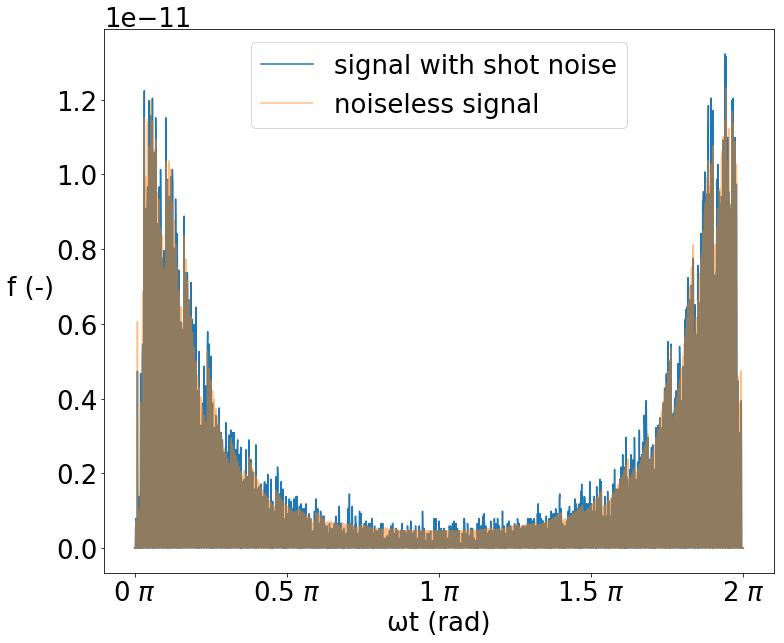

In [6]:
mpl.rcParams.update({'font.size': 26})
fig = plt.figure(figsize=[12,10])
ax = fig.add_subplot(111)
plt.plot((time_array/year*360)/180,f_noisy,label='signal with shot noise')
plt.plot((time_array/year*360)/180,f_curve,alpha=0.5,label='noiseless signal')
plt.legend()
# plt.plot(time_array/year,f_curve_edge_noisy,alpha=0.5)
ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%g $\pi$'))

plt.xlabel('ωt (rad)')
plt.ylabel('f (-)',rotation = 0,labelpad=25)
# plt.plot(f_curve_face,linewidth=0.1)
# plt.plot(f_curve_face_noisy,linewidth=0.1)
if burst:
    filename = 'f_curves/rangeburstsingleLCnoise'+ str(round(N_ave_full)) +'_seed'+str(seed_no)+'model'+model+'_n'+str(res)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+'.png'
else:
    filename = 'f_curves/rangesingleLCnoise'+ str(round(N_ave_full)) +'_seed'+str(seed_no)+'model'+model+'_n'+str(res)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+'.png'
os.makedirs(os.path.dirname(filename), exist_ok=True)
plt.savefig(filename,bbox_inches='tight',dpi=100)
plt.show()


In [7]:
%%time
'''
Compute inverse transfer matrix
'''

cutoff = 1/np.sqrt(N_ave_full)/2
T_pinv = np.linalg.pinv(T,rcond=1e-7)
T_pinv_noise = np.linalg.pinv(T,rcond = cutoff)
A = np.matmul(T_pinv,f_curve)/c_light
A_noise = np.matmul(T_pinv_noise,f_noisy)/c_light


Wall time: 3.16 s


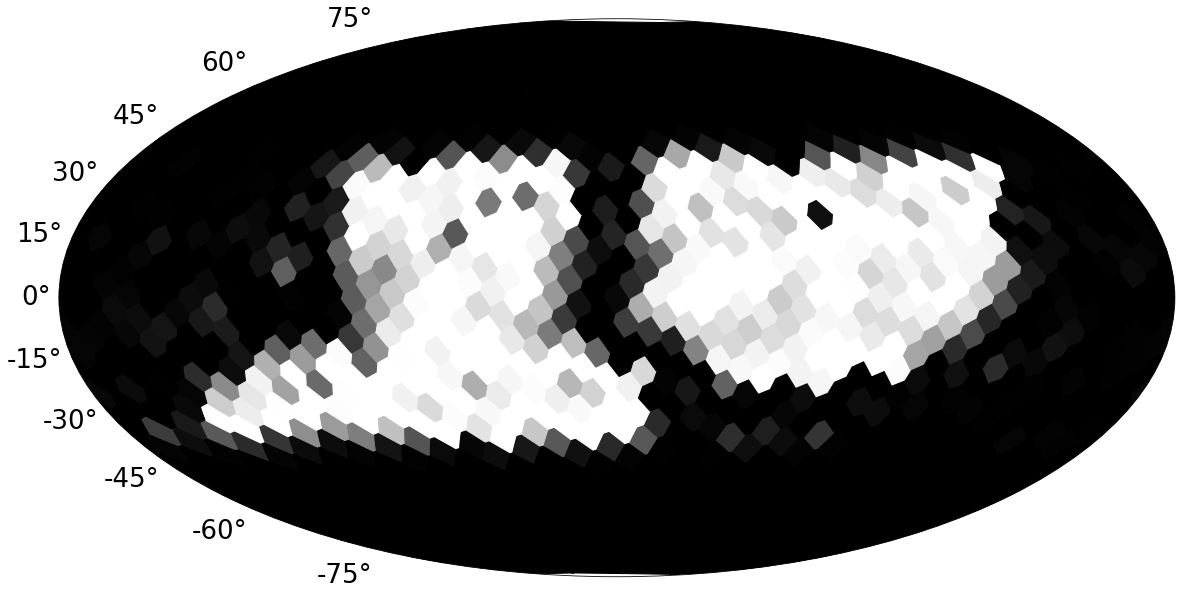

mean squared error:  227.6769215410413
Wall time: 3.91 s


In [8]:
%%time
if model == models[2]:
    blues = mpl.cm.get_cmap('Blues',4000) #colors
    greys = mpl.cm.get_cmap('Greys',4000)
    greys_r = mpl.cm.get_cmap('Greys_r',4000)

    mpl.rcParams.update({'font.size': 26})
    fig = plt.figure(figsize = [20,20])
    ax = fig.add_subplot(111,projection='mollweide')
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = greys_r)
    cmapplot.set_array([])
#     cb = fig.colorbar(cmapplot, ax=ax, orientation='horizontal', label='Albedo',shrink=1/1.5, aspect=40,pad=-0.6)

    # plot the facets
    ax.add_collection(PolyCollection(plot_facets_vor,array=A_noise,cmap=greys_r,edgecolor='face',norm=norm)) #plot majority of facets
    i=0
    for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
        c = greys_r(A_noise[i]/0.8)
        if np.any(facet_sph[:,0]>np.pi):
            ax.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
        elif np.any(facet_sph[:,0]<-np.pi):
            ax.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
        i+=1

    ax.set_xticklabels([])
#     ax.set_yticklabels([])
    filename = 'retrieved_albedo_range_indiv/noise'+str(seed_no)+'model'+model+'_n'+str(res)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+'_cutoff{:.0e}'.format(cutoff)+'.png'
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # remove x-ticks
    plt.savefig(filename,dpi=100,bbox_inches='tight')    
    plt.show()

else:
#     alts = copy.copy(A)
#     alts = alts-np.mean(alts)
#     max_alt = max(alts)
#     min_alt = min(alts)
#     norm_alts = (alts-min_alt)/(max_alt-min_alt)

    snowheight = 0.8
    soilheight = 0.4
    y1 = gist_earth(np.linspace(0.02,0.15,int(N*0.1))) #ocean colors
    y2 = gist_earth(np.linspace(0.3,0.5,int(N*0.2))) #forest colors
    y3 = gist_earth(np.linspace(0.7,0.85,int(N*0.2))) #soil colors
    y4 = gist_earth(np.linspace(0.93,1,int(N*.3))) #snow colors

    y = np.vstack((y1,y2,y3,y4))

    cmap_albedo = LinearSegmentedColormap.from_list('custom earth', y, N=256)

    mpl.rcParams.update({'font.size': 26})
    fig = plt.figure(figsize = [20,20])
    ax = fig.add_subplot(111,projection='mollweide')
    norm = mpl.colors.Normalize(vmin=0, vmax=0.8)
    cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = cmap_albedo)
    cmapplot.set_array([])
#     fig.colorbar(cmapplot, ax=ax, orientation='horizontal', label='albedo',shrink=1/1.5,aspect=40,pad=-.6)

    #plot facets
    ax.add_collection(PolyCollection(plot_facets_vor,array=A_noise,cmap=cmap_albedo,edgecolor='face',norm=norm)) #plot majority of facets
    i=0
    for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
        c = cmap_albedo(A_noise[i]/0.8)
        if np.any(facet_sph[:,0]>np.pi):
            ax.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
        elif np.any(facet_sph[:,0]<-np.pi):
            ax.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
        i+=1

    filename = 'retrieved_albedo_range_indiv/noise'+str(seed_no)+"_t"+str(time_res)+'model'+model+'_n'+str(res)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+'_cutoff{:.0e}'.format(cutoff)+'.png'
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # remove x-ticks
    plt.savefig(filename,dpi=100,bbox_inches='tight')
    plt.show()

MSE = (albedo_map - A_noise)**2
print('mean squared error: ',sum(MSE))

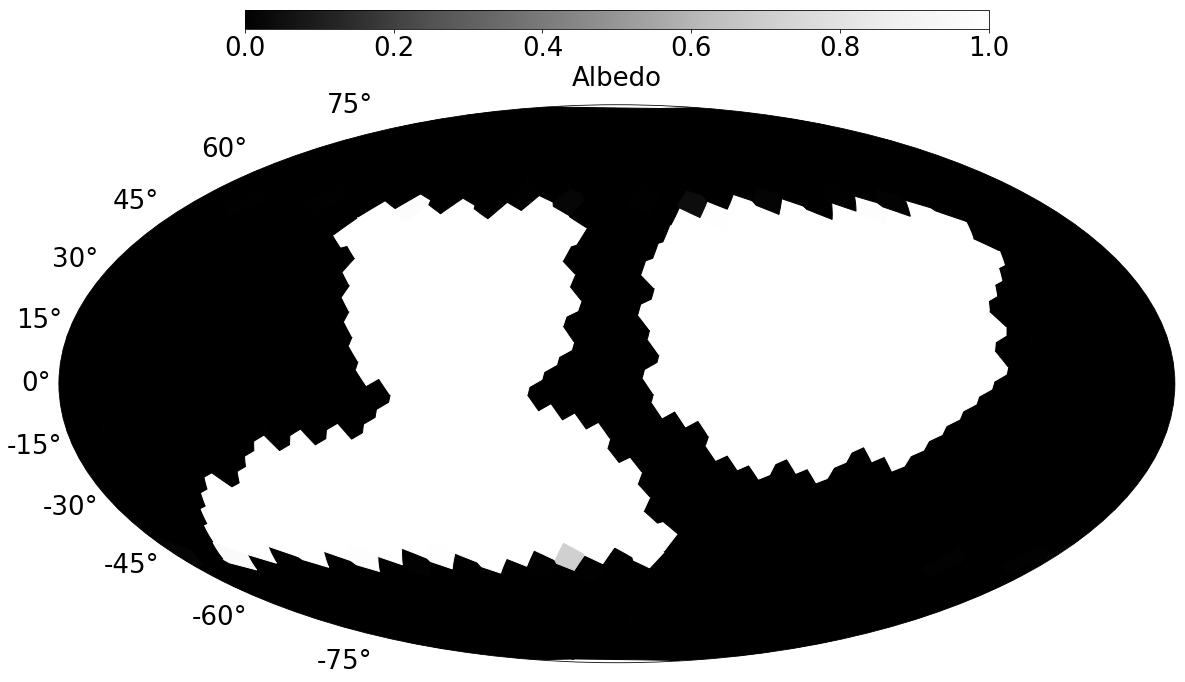

mean squared error:  227.6769215410413
Wall time: 4.12 s


In [9]:
%%time
if model == models[2]:
    mpl.rcParams.update({'font.size': 26})
    fig = plt.figure(figsize = [20,20])
    ax = fig.add_subplot(111,projection='mollweide')
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = greys_r)
    cmapplot.set_array([])
    cb = fig.colorbar(cmapplot, ax=ax, orientation='horizontal', label='Albedo',shrink=1/1.5, aspect=40,pad=-0.6)

    # plot the facets
    ax.add_collection(PolyCollection(plot_facets_vor,array=A,cmap=greys_r,edgecolor='face',norm=norm)) #plot majority of facets
    i=0
    for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
        c = greys_r(A[i]/0.8)
        if np.any(facet_sph[:,0]>np.pi):
            ax.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
        elif np.any(facet_sph[:,0]<-np.pi):
            ax.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
        i+=1

    ax.set_xticklabels([])
#     ax.set_yticklabels([])
    filename = 'retrieved_albedo_range_indiv/seed'+str(seed_no)+'model'+model+'_n'+str(res)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+'.png'
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # remove x-ticks
    plt.savefig(filename,dpi=100,bbox_inches='tight')    
    plt.show()

else:
#     alts = copy.copy(A_edge)
#     alts = alts-np.mean(alts)
#     max_alt = max(alts)
#     min_alt = min(alts)
#     norm_alts = (alts-min_alt)/(max_alt-min_alt)

    snowheight = 0.8
    soilheight = 0.4
    y1 = gist_earth(np.linspace(0.02,0.15,int(N*0.1))) #ocean colors
    y2 = gist_earth(np.linspace(0.3,0.5,int(N*0.2))) #forest colors
    y3 = gist_earth(np.linspace(0.7,0.85,int(N*0.2))) #soil colors
    y4 = gist_earth(np.linspace(0.93,1,int(N*.3))) #snow colors

    y = np.vstack((y1,y2,y3,y4))

    cmap_albedo = LinearSegmentedColormap.from_list('custom earth', y, N=256)

    mpl.rcParams.update({'font.size': 26})
    fig = plt.figure(figsize = [20,20])
    ax = fig.add_subplot(111,projection='mollweide')
    norm = mpl.colors.Normalize(vmin=0, vmax=0.8)
    cmapplot = mpl.cm.ScalarMappable(norm = norm, cmap = cmap_albedo)
    cmapplot.set_array([])
    fig.colorbar(cmapplot, ax=ax, orientation='horizontal', label='albedo',shrink=1/1.5,aspect=40,pad=-.6)

    #plot facets
    ax.add_collection(PolyCollection(plot_facets_vor,array=A,cmap=cmap_albedo,edgecolor='face',norm=norm)) #plot majority of facets
    i=0
    for facet_sph in plot_facets_vor: #deal with the facets over the edges by plotting them again with phi+-2pi
        c = cmap_albedo(A[i]/0.8)
        if np.any(facet_sph[:,0]>np.pi):
            ax.add_patch(patches.Polygon(np.stack((facet_sph[:,0]-2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
        elif np.any(facet_sph[:,0]<-np.pi):
            ax.add_patch(patches.Polygon(np.stack((facet_sph[:,0]+2*np.pi,facet_sph[:,1]),axis=1), fill = True, color = c))
        i+=1

    filename = 'retrieved_albedo_range_indiv/seed'+str(seed_no)+'model'+model+'_n'+str(res)+'_a'+str(round(alpha*180/np.pi))+'_b'+str(round(beta*180/np.pi))+'.png'
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # remove x-ticks
    plt.savefig(filename,dpi=100,bbox_inches='tight')
    plt.show()

MSE = (albedo_map - A_noise)**2
print('mean squared error: ',sum(MSE))